In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Beautiful format for float type
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [243]:
acc_x_card = pd.read_csv('tj_02_acc_x_card.csv')
account_transaction = pd.read_csv('tj_02_account_transaction.csv')
creditcard_transaction = pd.read_csv('tj_02_creditcard_transaction.csv')
data_train = pd.read_csv('tj_02_training.csv', header=None, names=["account_no", "is_merchant"])
data_test = pd.read_csv('tj_02_test.csv', header=None, names=["account_no"])

In [3]:
acc_x_card.info()
acc_x_card['card_no'].fillna(-1)
acc_x_card.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11652 entries, 0 to 11651
Data columns (total 2 columns):
account_no    11652 non-null int64
card_no       7593 non-null float64
dtypes: float64(1), int64(1)
memory usage: 182.1 KB


,account_no,card_no
0,3450028461,1234000000026194.000
1,3450033777,1234000000010556.000
2,3450003701,1234000000027765.000
3,3450038496,1234000000013169.000
4,3450035935,1234000000009252.000


### จำนวนคนที่มี card กับไม่มี

In [74]:
card_no = acc_x_card.groupby(["account_no"]).count()
card_no.head()

,card_no
account_no,
3450000010,1
3450000011,0
3450000012,0
3450000014,0
3450000015,0


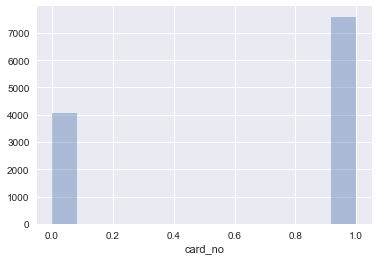

In [73]:
sns.distplot(card_no['card_no'], kde=False)

In [100]:
acc_x_card_x_merchant = data_train.copy()
acc_x_card_x_merchant = acc_x_card_x_merchant.join(card_no, on='account_no')

group_merchant_card = acc_x_card_x_merchant.groupby(['card_no', 'is_merchant']).count()
group_merchant_card.head()

account_no
card_no is_merchant            
0       0                  2117
        1                  1108
1       0                  4492
        1                  1604

In [245]:
account_transaction['day_of_week'] = pd.to_datetime(account_transaction['txn_dt']).dt.dayofweek
account_transaction.sample(3)

,account_no,from_to_account_no,txn_amount,txn_dt,txn_hour,txn_type,day_of_week,monday
1025096,3450001597,0,6000,2016-09-10,14,DR,5,False
387759,3450040167,3450647426,750,2016-06-06,10,CR,0,False
418303,3450040228,0,3000,2016-05-11,20,CR,2,False


In [155]:
def day_of_week_transaction(accounts, transactions):
    ret = accounts.copy()
    ret['t_sunday'] = ret.apply(lambda row: transactions[(transactions.account_no == row['account_no']) & \
                                 (transactions.day_of_week == 0)].shape[0], axis=1)
    return ret

test = day_of_week_transaction(data_train, account_transaction)



In [248]:
test = data_train.join(account_transaction.set_index('account_no'), on='account_no', how='left')
test = test[test['from_to_account_no'] != 0]
test2 = test[['account_no', 'is_merchant', 'day_of_week']].groupby(['account_no', 'is_merchant', 'day_of_week'])
test3 = test2.count().join(pd.DataFrame(test2.size(), columns=['counts'])).reset_index()

test3['t_sunday'] =    test3['counts'][test3['day_of_week'] == 0]
test3['t_monday'] =    test3['counts'][test3['day_of_week'] == 1]
test3['t_tuesday'] =   test3['counts'][test3['day_of_week'] == 2]
test3['t_wednesday'] = test3['counts'][test3['day_of_week'] == 3]
test3['t_thursday'] =  test3['counts'][test3['day_of_week'] == 4]
test3['t_friday'] =    test3['counts'][test3['day_of_week'] == 5]
test3['t_saturnday'] = test3['counts'][test3['day_of_week'] == 6]
test3 = test3.drop(['counts', 'day_of_week'], axis=1).fillna(0)


test4 = test3.groupby(['account_no', 'is_merchant']).sum().reset_index()
test4.head(10)

,account_no,is_merchant,t_sunday,t_monday,t_tuesday,t_wednesday,t_thursday,t_friday,t_saturnday
0,3450000010,1,127.000,85.000,80.000,87.000,87.000,75.000,78.000
1,3450000011,1,66.000,74.000,80.000,69.000,82.000,47.000,51.000
2,3450000012,1,7.000,7.000,6.000,3.000,3.000,3.000,7.000
3,3450000014,1,467.000,455.000,422.000,442.000,337.000,238.000,277.000
4,3450000017,0,1.000,0.000,0.000,0.000,0.000,0.000,0.000
5,3450000018,0,0.000,3.000,0.000,0.000,0.000,0.000,0.000
6,3450000028,1,32.000,31.000,30.000,28.000,29.000,41.000,37.000
7,3450000029,1,21.000,8.000,21.000,17.000,17.000,18.000,7.000
8,3450000030,0,1.000,1.000,1.000,0.000,1.000,1.000,0.000
9,3450000034,1,98.000,106.000,85.000,97.000,104.000,7.000,7.000


### Try to use features

In [250]:
from sklearn.model_selection import train_test_split

X_all = test4.drop(['account_no', 'is_merchant'], axis=1)
y_all = test4['is_merchant']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [258]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=13, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [263]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

# WTF

In [264]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.76699669967


In [253]:
X_train.shape

(6058, 7)

In [260]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(6058, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.801980198019802
Fold 2 accuracy: 0.8052805280528053
Fold 3 accuracy: 0.7838283828382838
Fold 4 accuracy: 0.7887788778877888
Fold 5 accuracy: 0.8151815181518152
Fold 6 accuracy: 0.8003300330033003
Fold 7 accuracy: 0.7706270627062707
Fold 8 accuracy: 0.7904290429042904
Fold 9 accuracy: 0.7834710743801653
Fold 10 accuracy: 0.7801652892561983
Mean Accuracy: 0.7920072007200721


In [257]:
test = data_test.join(account_transaction.set_index('account_no'), on='account_no', how='left')

test2 = test[['account_no', 'day_of_week']].groupby(['account_no', 'day_of_week'])
test3 = test2.count().join(pd.DataFrame(test2.size(), columns=['counts'])).reset_index()

test3['t_sunday'] =    test3['counts'][test3['day_of_week'] == 0]
test3['t_monday'] =    test3['counts'][test3['day_of_week'] == 1]
test3['t_tuesday'] =   test3['counts'][test3['day_of_week'] == 2]
test3['t_wednesday'] = test3['counts'][test3['day_of_week'] == 3]
test3['t_thursday'] =  test3['counts'][test3['day_of_week'] == 4]
test3['t_friday'] =    test3['counts'][test3['day_of_week'] == 5]
test3['t_saturnday'] = test3['counts'][test3['day_of_week'] == 6]
test3 = test3.drop(['counts', 'day_of_week'], axis=1).fillna(0)


test4 = test3.groupby(['account_no']).sum().reset_index()

ids = test4['account_no']
predictions = clf.predict(test4.drop('account_no', axis=1))


output = pd.DataFrame({ 'account_no' : ids, 'is_merchant': predictions })
output.to_csv('2.csv', index = False, header=None)
output.head(200)

,account_no,is_merchant
0,3450000015,0
1,3450000024,1
2,3450000027,1
3,3450000031,1
4,3450000032,1
5,3450000033,1
6,3450000039,0
7,3450000044,0
8,3450000047,1
9,3450000049,1
